# Baseline Sensitivity Study for a pulse of 7keK without noise

How would 0-padding respond to a change in the baseline?

* Simulate 7 keV pulse (no jitter, nonoise) Tbath=nominal
* Simulate 7 keV pulse (no jitter, nonoise) Tbath=nominal + 1uK
* Reconstruct with 0-padding (at different lengths)
* Reconstruct with short filters (at different lengths) for comparison
* Compare E(Tb)-E(Tb+) with the results obtained with OPTFILT8192


In [1]:
# ----IMPORT MODULES --------------
from __future__ import print_function
from __future__ import division
from multiprocessing import Pool, cpu_count
from itertools import repeat
from subprocess import check_call, check_output,STDOUT
from cycler import cycler
from astropy.io import fits
from scipy.stats import norm
from statistics import mean
import math
import sys, os
import shutil, tempfile, shlex
import re
import warnings
import numpy as np
from sklearn.metrics import mean_squared_error
from numpy.polynomial import Polynomial
import auxpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from numpy import genfromtxt

cwd = os.getcwd()
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"
eurecaDir = "/dataj6/ceballos/INSTRUMEN/EURECA"
sixteDir = eurecaDir + "/testHarness/simulations/SIXTE"
sixteInst = os.environ["SIXTE"] + "/share/sixte/instruments/athena-xifu/"
#sixteInst = "/dataj4/software/SIXTE/git/gitInstall" + "/share/sixte/instruments/athena-xifu/"
xmlfile = sixteInst + "/xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml"
libDir = eurecaDir + "/testHarness/simulations/SIXTE/LIBRARIES/xifusimLPA75um/GLOBAL/ADC/"
bslDir = eurecaDir + "/ERESOL/baselineSensitivity/"

# Define variables 

In [2]:
#pulseLength=(128,256,512,1024,1500,2048,2500,3000,3500,4096,4500, 5000, 5500, 6000,7000, 8192) # or shorter lengths
pulseLength=(128,256,512,1024,2048,4096,8192) # or shorter lengths
ofLength=(128,256,512,1024,2048,4096,8192) # for 0-padding or shorter filters otherwise


# ... and filenames

In [3]:
name = "pulse7keVnonoise"
name_TBhigher = "pulse7keVnonoise_TBhigher"

inputFile = bslDir + name + ".fits"
inputFile_TBhigher = bslDir + name_TBhigher + ".fits"

libfile = libDir + "library6keV_PL8192_20000p_jitter_bbfb_NewPar.fits"
#xmlfile = "/home/EURECA/share/sixte/instruments/athena-xifu/xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml"

# a) Filenames for 0-padding 
# ========================================================
evtFs = list()
evtFs_calib = list()
evtTBFs = list()
evtTBFs_calib = list()

for i in range(0,len(pulseLength)):    
    file = (bslDir + name + "_pL" + str(pulseLength[i]) + ".fits")
    #print(file)
    evtFs.append(file)
    
    file = (bslDir + name + "_pL" + str(pulseLength[i]) + "_HR.calib")
    #print(file)
    evtFs_calib.append(file)
    
    file = (bslDir + name + "_TBhigher_pL" + str(pulseLength[i]) + ".fits")
    #print(file)
    evtTBFs.append(file)
    
    file = (bslDir + name + "_TBhigher_pL" + str(pulseLength[i]) + "_HR.calib")
    #print(file)
    evtTBFs_calib.append(file)

# a) Optimal Filtering (short filters)
# ====================================
evtFs_OPTFILT = list()
evtFs_calib_OPTFILT = list()
evtTBFs_OPTFILT = list()
evtTBFs_calib_OPTFILT = list()

for i in range(0,len(ofLength)):    
    file = (bslDir + name + "_OPTFILT" + str(ofLength[i]) + ".fits")
    #print(file)
    evtFs_OPTFILT.append(file)
    
    file = (bslDir + name + "_OPTFILT" + str(ofLength[i]) + "_HR.calib")
    #print(file)
    evtFs_calib_OPTFILT.append(file)
    
    file = (bslDir + name + "_TBhigher_OPTFILT" + str(ofLength[i]) + ".fits")
    #print(file)
    evtTBFs_OPTFILT.append(file)
    
    file = (bslDir + name + "_TBhigher_OPTFILT" + str(ofLength[i]) + "_HR.calib")
    #print(file)
    evtTBFs_calib_OPTFILT.append(file)

# Run 0-padding


In [4]:
# RECONSTRUCT by using 0-padding
run = 0
if run:
    for i in range(0,len(pulseLength)):
        if not os.path.isfile(evtFs[i]):
            comm = ("tesreconstruction Recordfile=" + inputFile + " TesEventFile=" + evtFs[i] + 
                    " Rcmethod=SIRENA" + " PulseLength="+ str(pulseLength[i]) + 
                    " LibraryFile=" + libfile + " samplesUp=3 nSgms=3.5 samplesDown=4" + 
                    " opmode=1 OFLib=yes FilterDomain=T detectionMode=STC Fitting35=3" + 
                    " FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=OPTFILT" + 
                    " LagsOrNot=1 filtEeV=6000.0 OFStrategy=FIXED OFLength=8192" +
                    " XMLFile=" + xmlfile)
            try:
                print("Reconstructing: ", evtFs[i])
                #print(comm)
                args = shlex.split(comm)
                check_call(args, stderr=STDOUT)
            except:
                print("Error running tool for SIRENA reconstruction with command:\n", comm)
                shutil.rmtree(tmpDir)
                raise
            
        if not os.path.isfile(evtTBFs[i]):
            comm = ("tesreconstruction Recordfile=" + inputFile_TBhigher + " TesEventFile=" + evtTBFs[i] +
                    " Rcmethod=SIRENA PulseLength="+ str(pulseLength[i]) + " LibraryFile=" + libfile +
                    " samplesUp=3 nSgms=3.5 samplesDown=4 opmode=1 OFLib=yes FilterDomain=T" + 
                    " detectionMode=STC Fitting35=3 FilterMethod=F0 clobber=yes EventListSize=1000 " + 
                    " EnergyMethod=OPTFILT LagsOrNot=1 filtEeV=6000.0 OFStrategy=FIXED OFLength=8192" +
                    " XMLFile=" + xmlfile)
            try:
                print("Reconstructing: ", evtTBFs[i])
                #print(comm)
                args = shlex.split(comm)
                check_call(args, stderr=STDOUT)
            except:
                print("Error running tool for SIRENA reconstruction with command:\n", comm)
                shutil.rmtree(tmpDir)
                raise
    print("===================================================")
    print("0-padding reconstruction finished for Tbath(+0.1uK)")
    print("===================================================")
        

# Run OPTIMAL FILTER


In [5]:
# RECONSTRUCT by using OPTIMAL FILTERING
run = 0
if run:
    for i in range(0,len(ofLength)):
        comm = ("tesreconstruction Recordfile=" + inputFile + " TesEventFile=" + evtFs_OPTFILT[i] + " Rcmethod=SIRENA" + 
            " PulseLength=8192" + " LibraryFile=" + libfile +
            " samplesUp=3" + " nSgms=3.5" + " samplesDown=4" + 
            " opmode=1 OFLib=yes FilterDomain=T" + " detectionMode=STC Fitting35=3" + 
            " FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=OPTFILT" + 
            " LagsOrNot=1" +
            " XMLFile=" + xmlfile + " filtEeV=6000.0 OFStrategy=FIXED OFLength=" + str(ofLength[i]))
        try:
            print("Reconstructing: ", evtFs_OPTFILT[i])
            #print(comm)
            args = shlex.split(comm)
            check_call(args, stderr=STDOUT)
        except:
            print("Error running tool for SIRENA reconstruction with command:\n", comm)
            shutil.rmtree(tmpDir)
            raise
                
        comm = ("tesreconstruction Recordfile=" + inputFile_TBhigher + " TesEventFile=" + evtTBFs_OPTFILT[i] + " Rcmethod=SIRENA" + 
            " PulseLength=8192" + " LibraryFile=" + libfile +
            " samplesUp=3" + " nSgms=3.5" + " samplesDown=4" + 
            " opmode=1 OFLib=yes FilterDomain=T" + " detectionMode=STC Fitting35=3" + 
            " FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=OPTFILT" + 
            " LagsOrNot=1" +
            " XMLFile=" + xmlfile + " filtEeV=6000.0 OFStrategy=FIXED OFLength=" + str(ofLength[i]))
        try:
            print("Reconstructing: ", evtTBFs_OPTFILT[i])
            #print(comm)
            args = shlex.split(comm)
            check_call(args, stderr=STDOUT)
        except:
            print("Error running tool for SIRENA reconstruction with command:\n", comm)
            shutil.rmtree(tmpDir)
            raise

# CALIBRATE 0-padding files


In [6]:
run = 0
if run:
    coeffsFile = "/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um_xifusim/coeffs_polyfit_methods_NewPar.dat"
    for i in range(0,len(pulseLength)):
        alias = "pL" + str(pulseLength[i]) + "_STC_T_fixedlib6OF_OPTFILT8192_nonoise_bbfb_NewPar"
        auxpy.convertEnergies(evtFs[i],evtFs_calib[i],coeffsFile,alias)
        
        auxpy.convertEnergies(evtTBFs[i],evtTBFs_calib[i],coeffsFile,alias)

...Calculating corrected energies for pulses in  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_pL128.fits
Reading curve coefficients from /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um_xifusim/coeffs_polyfit_methods_NewPar.dat 

...Calculating corrected energies for pulses in  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_TBhigher_pL128.fits
Reading curve coefficients from /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um_xifusim/coeffs_polyfit_methods_NewPar.dat 

...Calculating corrected energies for pulses in  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_pL256.fits
Reading curve coefficients from /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um_xifusim/coeffs_polyfit_methods_NewPar.dat 

...Calculating corrected energies for pulses in  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_TBhigher_pL256.fits
Reading curve coeff

# CALIBRATE OPTIMAL FILTERING files


In [7]:
run = 0
if run:
    coeffsFile = "/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um_xifusim/coeffs_polyfit_methods_NewPar.dat"
    for i in range(0,len(ofLength)):
        alias = "pL8192_STC_T_fixedlib6OF_OPTFILT" + str(ofLength[i]) + "_nonoise_bbfb_NewPar"
        auxpy.convertEnergies(evtFs_OPTFILT[i],evtFs_calib_OPTFILT[i],coeffsFile,alias)
        
        auxpy.convertEnergies(evtTBFs_OPTFILT[i],evtTBFs_calib_OPTFILT[i],coeffsFile,alias)

...Calculating corrected energies for pulses in  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_OPTFILT128.fits
Reading curve coefficients from /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um_xifusim/coeffs_polyfit_methods_NewPar.dat 

...Calculating corrected energies for pulses in  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_TBhigher_OPTFILT128.fits
Reading curve coefficients from /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um_xifusim/coeffs_polyfit_methods_NewPar.dat 

...Calculating corrected energies for pulses in  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_OPTFILT256.fits
Reading curve coefficients from /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um_xifusim/coeffs_polyfit_methods_NewPar.dat 

...Calculating corrected energies for pulses in  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_TBhigher_OPTFILT256.fits

# Read the OPTIMAL FILTERING baseline sensitivity

In [8]:
run = 1
if run:
    
    # No calibrated
    nocalib_OPTFILT = list()
    TBhigher_nocalib_OPTFILT = list()
    
    calib_OPTFILT = list()
    TBhigher_calib_OPTFILT = list()
    
    for i in range (0,len(ofLength)):
        file = fits.open(evtFs_OPTFILT[i], memmap=True)
        fileTab = file[1].data
        fileSIGNAL = fileTab['SIGNAL']
        file.close()
        
        nocalib_OPTFILT.append(fileSIGNAL[0])
    
        file = fits.open(evtTBFs_OPTFILT[i], memmap=True)
        fileTab = file[1].data
        fileSIGNAL = fileTab['SIGNAL']
        file.close()
        
        TBhigher_nocalib_OPTFILT.append(fileSIGNAL[0])
        
        file = fits.open(evtFs_calib_OPTFILT[i], memmap=True)
        fileTab = file[1].data
        fileSIGNAL = fileTab['SIGNAL']
        file.close()
        
        calib_OPTFILT.append(fileSIGNAL[0])
    
        file = fits.open(evtTBFs_calib_OPTFILT[i], memmap=True)
        fileTab = file[1].data
        fileSIGNAL = fileTab['SIGNAL']
        file.close()
        
        TBhigher_calib_OPTFILT.append(fileSIGNAL[0])
        

# Read the 0-PADDING baseline sensitivity

In [9]:
run = 1
if run:
    # #Read opt filt in T
    libDir = eurecaDir + "/testHarness/simulations/SIXTE/LIBRARIES/xifusimLPA75um/GLOBAL/ADC/"
    ft = genfromtxt(libDir + 'library6keV_PL8192_20000p_jitter_bbfb_FT8192.txt', delimiter=" ")
    pl = genfromtxt(libDir + 'library6keV_PL8192_20000p_jitter_bbfb_pulse.txt', delimiter=" ")
    
    # No calibrated
    nocalib = list()
    TBhigher_nocalib = list()
    
    calib = list()
    TBhigher_calib = list()
    
    for i in range (0,len(pulseLength)):
        file = fits.open(evtFs[i], memmap=True)
        fileTab = file[1].data
        fileSIGNAL = fileTab['SIGNAL']
        file.close()
        
        nocalib.append(fileSIGNAL[0])
    
        file = fits.open(evtTBFs[i], memmap=True)
        fileTab = file[1].data
        fileSIGNAL = fileTab['SIGNAL']
        file.close()
        
        TBhigher_nocalib.append(fileSIGNAL[0])
        
        file = fits.open(evtFs_calib[i], memmap=True)
        fileTab = file[1].data
        fileSIGNAL = fileTab['SIGNAL']
        file.close()
        
        calib.append(fileSIGNAL[0])
    
        file = fits.open(evtTBFs_calib[i], memmap=True)
        fileTab = file[1].data
        fileSIGNAL = fileTab['SIGNAL']
        file.close()
        
        TBhigher_calib.append(fileSIGNAL[0])
        
    

# PLOT OPTFILT & 0-PADDING Baseline Sensitivity

In [12]:
# only one Y axis...deprecated...


AE_eV_nocalib = list()
AE_eV_calib = list()
AE_eV_nocalib_OPTFILT = list()
AE_eV_calib_OPTFILT = list()

# 0-padding
for i in range(0,len(pulseLength)):
    #AE_eV_nocalib.append((nocalib[i]-TBhigher_nocalib[i])*1e3/0.1) # +0.1uK TBhigher with respect to TB=55mK
    # Tbath=55mK and Tbath_higher=0.055001 (i.e. + 1uK)
    AE_eV_nocalib.append((nocalib[i]-TBhigher_nocalib[i])*1e3) 
    AE_eV_calib.append((calib[i]-TBhigher_calib[i])*1e3) # +1uK TBhigher with respect to TB=55mK    

for i in range(0,len(ofLength)):    
    # Tbath=55mK and Tbath_higher=0.055001 (i.e. + 1uK)
    AE_eV_nocalib_OPTFILT.append((nocalib_OPTFILT[i]-TBhigher_nocalib_OPTFILT[i])*1e3) 
    AE_eV_calib_OPTFILT.append((calib_OPTFILT[i]-TBhigher_calib_OPTFILT[i])*1e3) 

run=0
if run:
    fig = plt.figure(figsize=(16,6))
    fig.suptitle('0-padding/OPTFILT Baseline Sensitivity', fontsize=14, fontweight='bold')

    plt.plot(pulseLength,AE_eV_nocalib, marker='o', linestyle='--', ms=5,
             label='ΔPH ADC-0-padding (uncalib)',color='blue')
    plt.plot(pulseLength,AE_eV_calib, marker='o', linestyle='solid', ms=5, 
             label='ΔE ADC-0-padding (calib)',color='blue')

    plt.plot(ofLength,AE_eV_nocalib_OPTFILT, marker='o', linestyle='--', ms=5,
             label='ΔPH ADC-Short filter (uncalib)',color='orange')
    plt.plot(ofLength,AE_eV_calib_OPTFILT, marker='o', linestyle='solid', ms=5,
             label='ΔPH ADC-Short filter (calib)',color='orange')

    #plt.axhline(y=AE_eV_nocalib_OPTFILT[6],linestyle='--',color='red',label="OPTFILT8192")
    plt.plot(list(range(0,8192)),ft/100,linestyle='-',color='black',label="Filter/100")
    plt.plot(list(range(0,8192)),pl/1E5,linestyle='-',color='green',label="Pulse/1E5")
    plt.legend()
    plt.ylabel('ΔE (eV/µK)')
    plt.xlabel('0-padding or filter length (samples)')
    plt.grid(True)
    plt.ylim(-0.5,0.5)
    plt.show()


    #fig.savefig('baselineSensitivity0padding_zoom.png', dpi=fig.dpi)



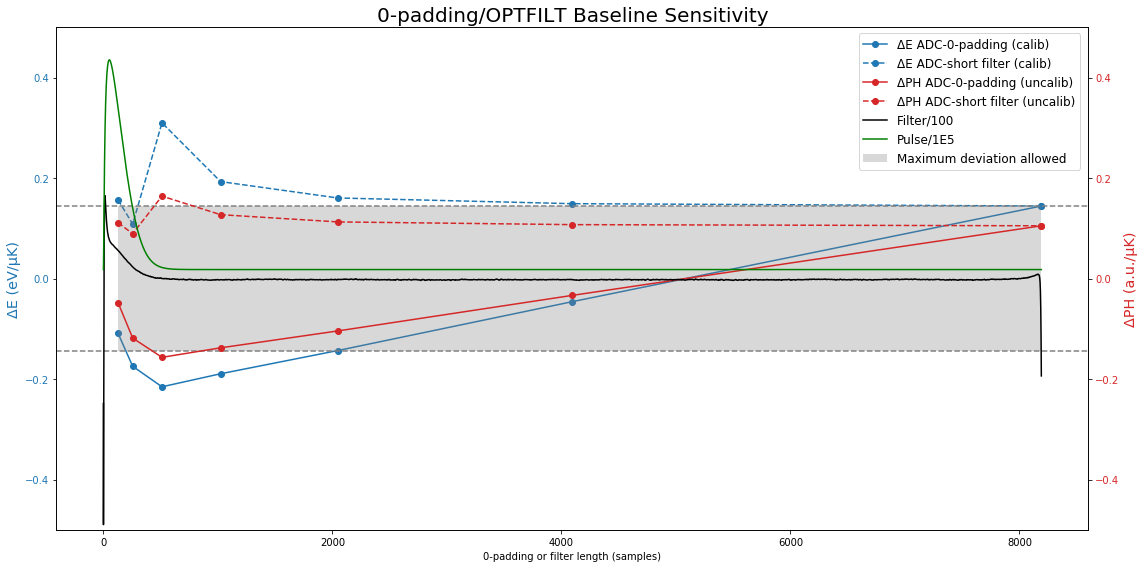

In [13]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1, 1, 1)
#fig.suptitle('0-padding/OPTFILT Baseline Sensitivity', fontsize=14, fontweight='bold')

title = ax1.set_title("0-padding/OPTFILT Baseline Sensitivity", fontsize=20)
ax1.set_ylim(-0.5, 0.5)

color = 'tab:blue'
ax1.set_xlabel('0-padding or filter length (samples)')
ax1.set_ylabel('ΔE (eV/µK)', color=color, fontsize='x-large')
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(pulseLength,AE_eV_calib, marker='o', linestyle='-', color=color, label='ΔE ADC-0-padding (calib)' )
ax1.plot(ofLength,AE_eV_calib_OPTFILT,marker='o', linestyle='--', color=color, label='ΔE ADC-short filter (calib)' )
ax1.axhline(y=AE_eV_calib_OPTFILT[6],linestyle='--',color='gray')
ax1.axhline(y=-AE_eV_calib_OPTFILT[6],linestyle='--',color='gray')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylim(-0.5, 0.5)

color = 'tab:red'
ax2.set_ylabel('ΔPH (a.u./µK)', color=color, fontsize='x-large')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(pulseLength,AE_eV_nocalib, marker='o', color=color, linestyle='-', label='ΔPH ADC-0-padding (uncalib)')
ax2.plot(ofLength,AE_eV_nocalib_OPTFILT, marker='o', color=color, linestyle='--', label='ΔPH ADC-short filter (uncalib)')

ax2.plot(list(range(0,8192)),ft/100,linestyle='-',color='black',label="Filter/100")
ax2.plot(list(range(0,8192)),pl/1E5,linestyle='-',color='green',label="Pulse/1E5")
ax2.fill_between(ofLength,-AE_eV_calib_OPTFILT[6], +AE_eV_calib_OPTFILT[6], facecolor="gray", alpha=0.3, label="Maximum deviation allowed")
fig.legend(loc=(0.75,0.7),fontsize='large')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.grid(True)
plt.show()
fig.savefig('baselineSensitivity0padding.png', dpi=fig.dpi)